In [62]:
import os
#import cv2
import glob
import pathlib
import PIL, PIL.Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from PIL import Image

In [63]:
base_dir = os.getcwd()
print(f'current directory: {base_dir}')

dataset_dir = pathlib.Path(os.path.join(base_dir, 'Images'))
print(f'datasets directory: {dataset_dir}')

current directory: c:\Users\20221750\Documents\GitHub\TUe-Honors-MedAI\VGG19
datasets directory: c:\Users\20221750\Documents\GitHub\TUe-Honors-MedAI\VGG19\Images


In [64]:
image_count = len(list(dataset_dir.glob('**/*.jpg')))
print('number of total images:', image_count, '\n\n')

number of total images: 44 




In [65]:
batch_size = 5
img_height = 500
img_width = 500

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 44 files belonging to 2 classes.
Using 36 files for training.
Found 44 files belonging to 2 classes.
Using 8 files for validation.
['Consc', 'Notconsc']


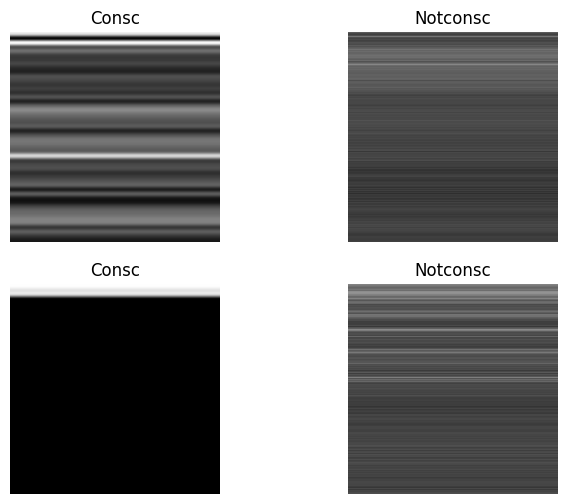

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [67]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(5, 500, 500, 3)
(5,)


In [69]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**VGG19 Model**

In [71]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
num_classes = len(class_names)

model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(500, 500, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same', strides=(2, 2)))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same', strides=(2, 2)))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same', strides=(2, 2)))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same', strides=(2, 2)))

# Classification block
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 
model.summary()

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

model.fit(train_ds, validation_data=val_ds, epochs=3)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 500, 500, 64)      1792      
                                                                 
 conv2d_65 (Conv2D)          (None, 500, 500, 64)      36928     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 250, 250, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_66 (Conv2D)          (None, 250, 250, 128)     73856     
                                                                 
 conv2d_67 (Conv2D)          (None, 250, 250, 128)     147584    
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 125, 125, 128)     0         
 ng2D)                                                

c:\Users\20221750\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\layer_utils.py:146: RuntimeWarning: overflow encountered in scalar multiply
  total_memory_size += weight_shape * per_param_size


Epoch 1/3
8/8 [==============================] - 216s 27s/step - loss: 1.0298 - accuracy: 0.4722 - val_loss: 0.6756 - val_accuracy: 0.5000
Epoch 2/3
8/8 [==============================] - 231s 29s/step - loss: 0.6588 - accuracy: 0.6944 - val_loss: 0.5496 - val_accuracy: 0.8750
Epoch 3/3
8/8 [==============================] - 201s 25s/step - loss: 0.3341 - accuracy: 0.9167 - val_loss: 0.9283 - val_accuracy: 0.8750


**Evaluations**

In [78]:
def evaluate(model, name='model'):
  loss, acc = model.evaluate(val_ds, batch_size= batch_size)
  print(f"{name}'s accuracy: {round((acc * 100), 2)}%")

evaluate(model, 'VGG19 CNN')

2/2 [==============================] - 3s 1s/step - loss: 0.9283 - accuracy: 0.8750
VGG19 CNN's accuracy: 87.5%
